##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

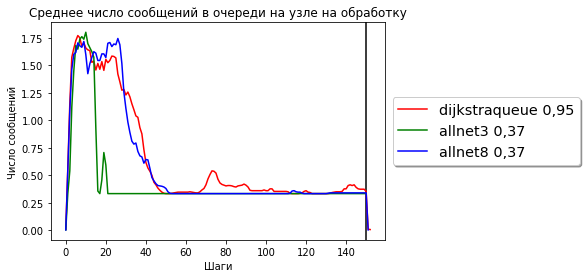

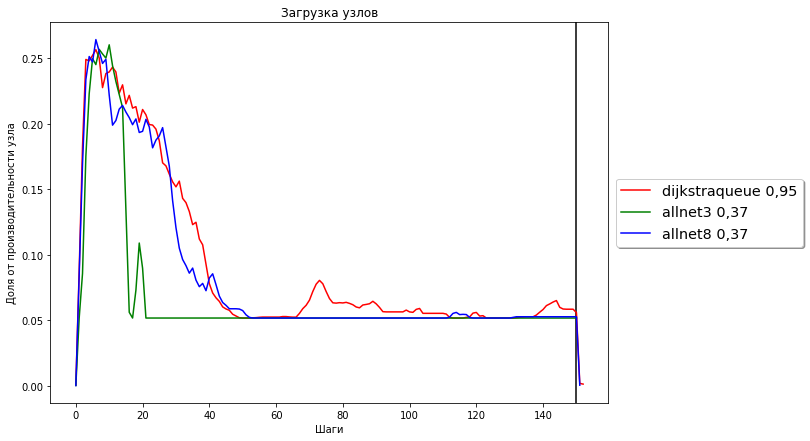

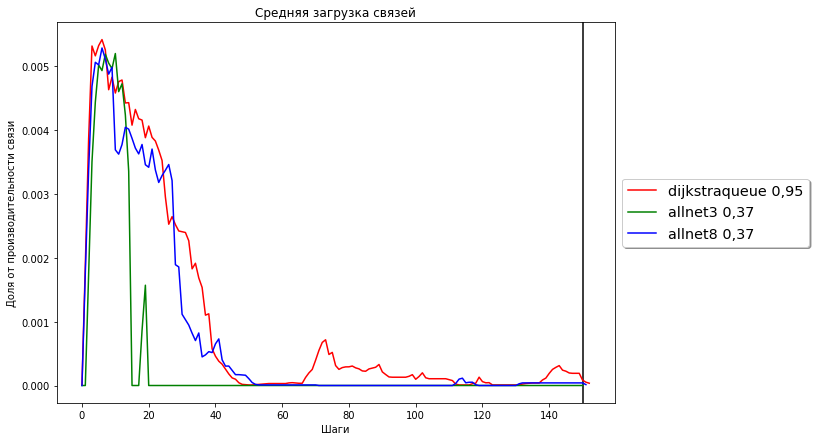

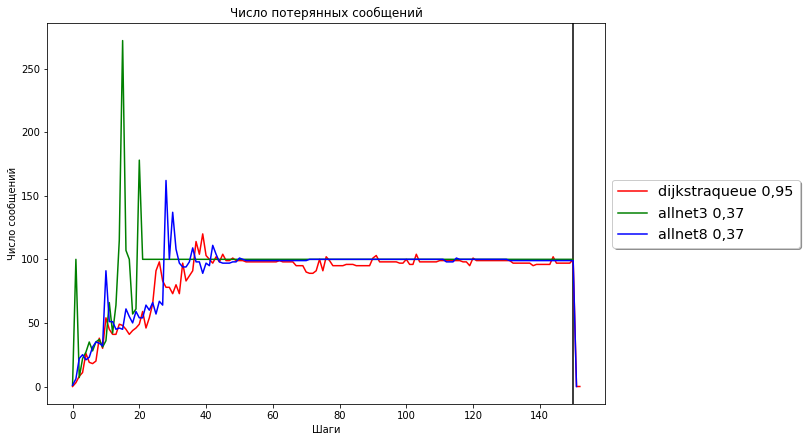

Доставлено 1913 Потеряно 87.2475% -dijkstraqueue 0,95
Доставлено 580 Потеряно 96.1336% -allnet3 0,37
Доставлено 1398 Потеряно 90.6806% -allnet8 0,37


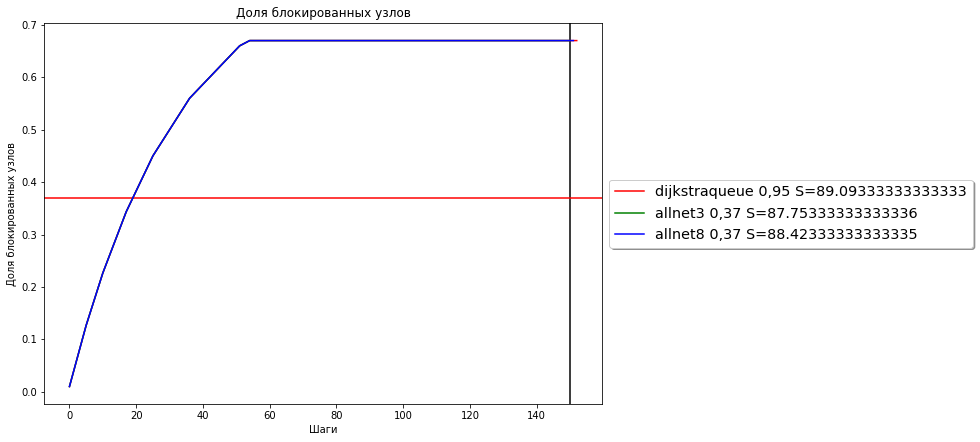

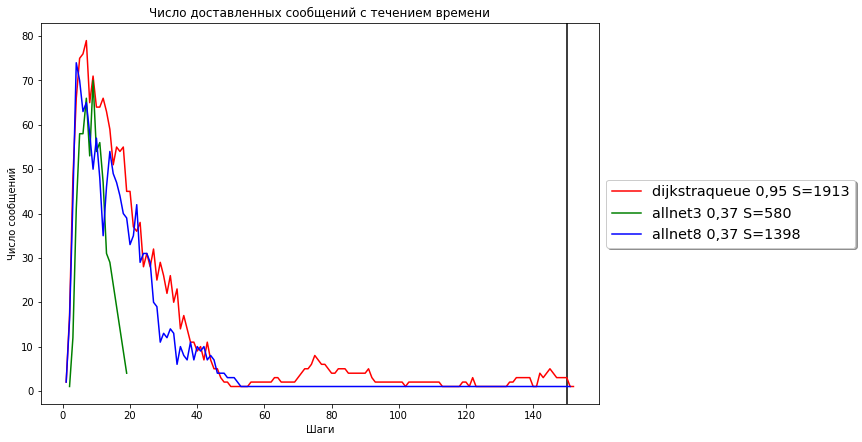

In [2]:
quantity = 100;
log_tags = [
{"tag":  "765b0393-a76b-49ed-b44b-a6739be545cd", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d04ef090-d58e-410d-af1a-632afadbf1ca", "label": "allnet3 0,37", "color": "green"},
{"tag":  "16e9db84-7c73-4a84-b9cc-9fb21784c17a", "label": "allnet8 0,37", "color": "blue"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

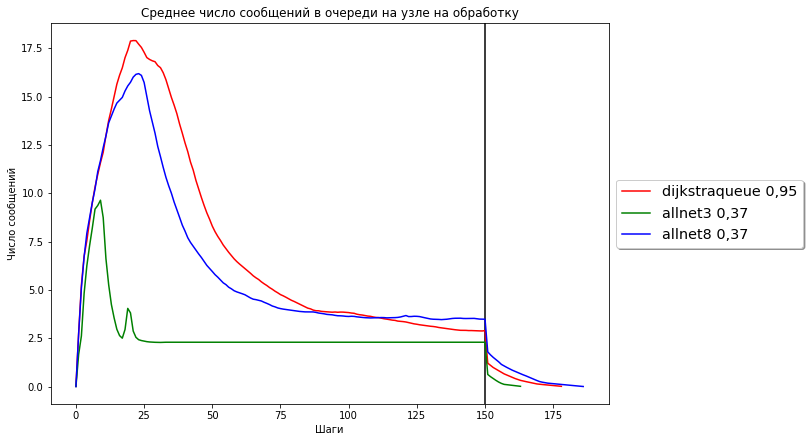

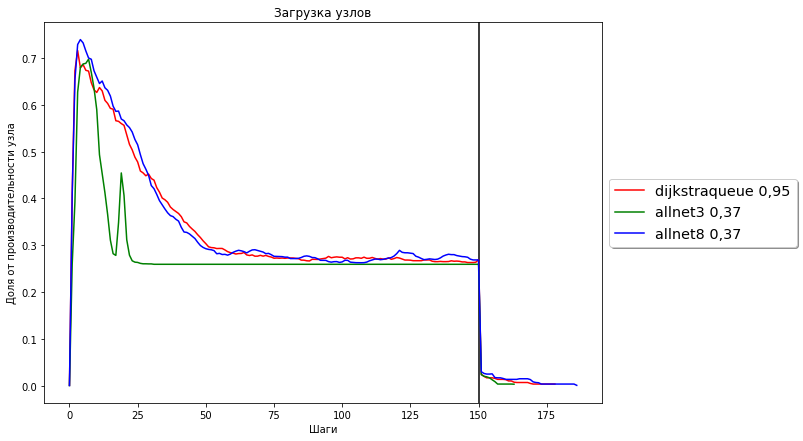

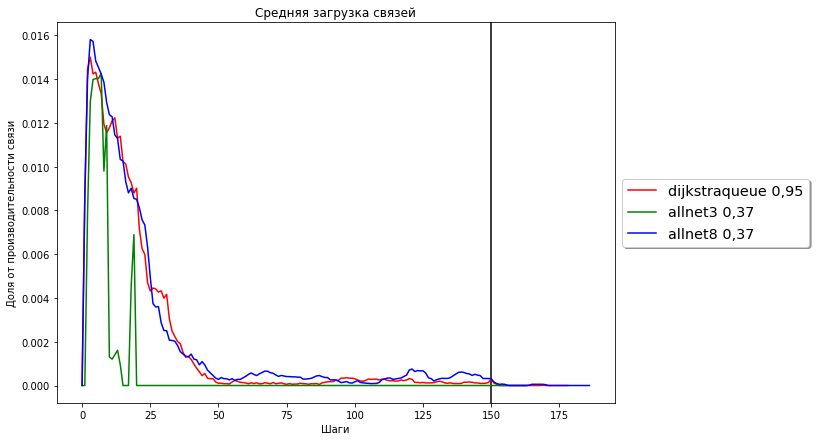

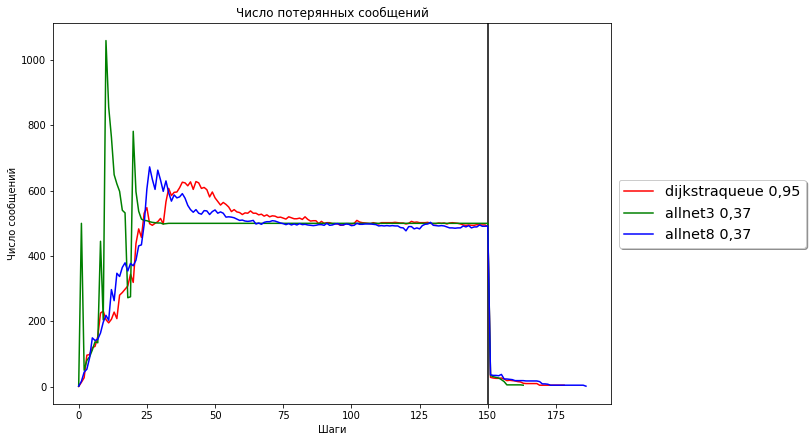

Доставлено 2741 Потеряно 96.3454% -dijkstraqueue 0,95
Доставлено 937 Потеряно 98.7507% -allnet3 0,37
Доставлено 3466 Потеряно 95.3787% -allnet8 0,37


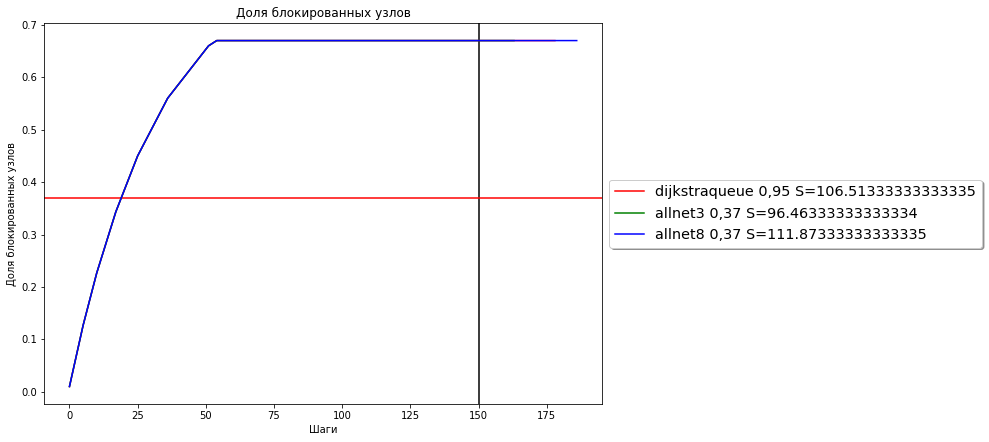

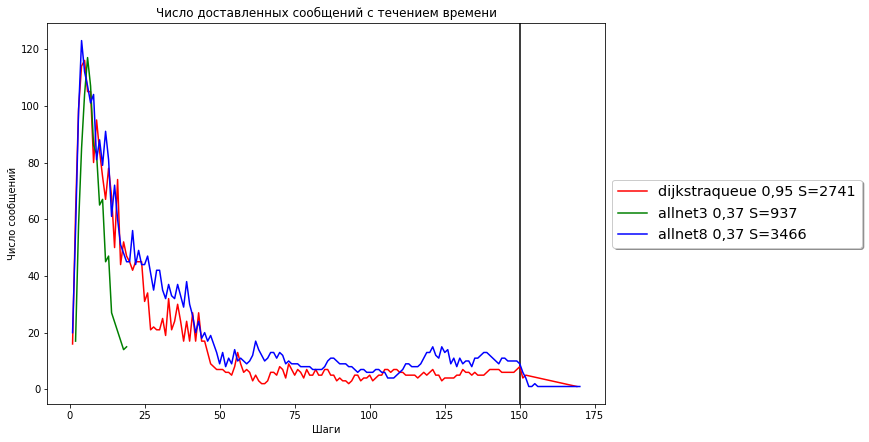

In [3]:
quantity = 500;
log_tags = [
{"tag":  "b61e4ac1-ea3f-4722-ba43-580ccf697a7f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1f155336-15e2-4458-a596-6e70cafb00b3", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ea1ef62e-79df-414b-8f67-c451702810e2", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

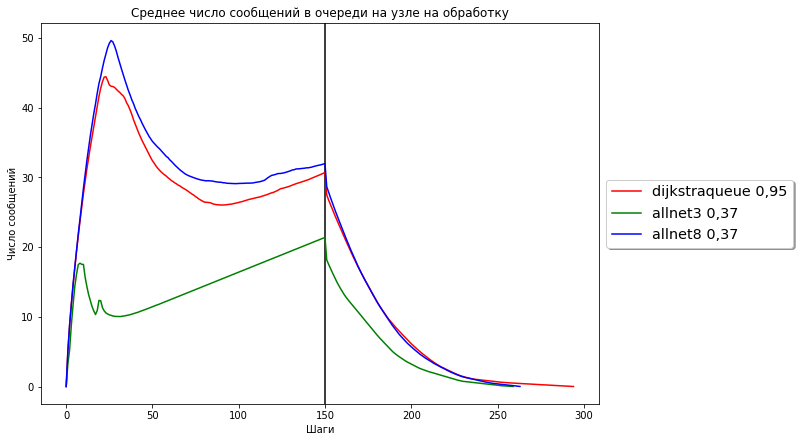

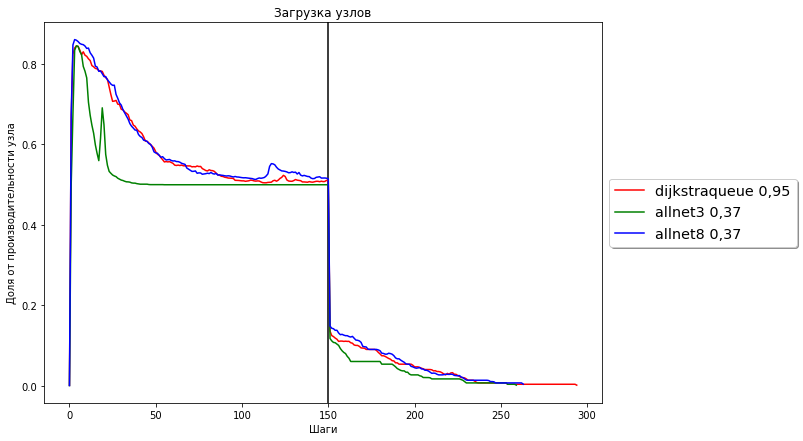

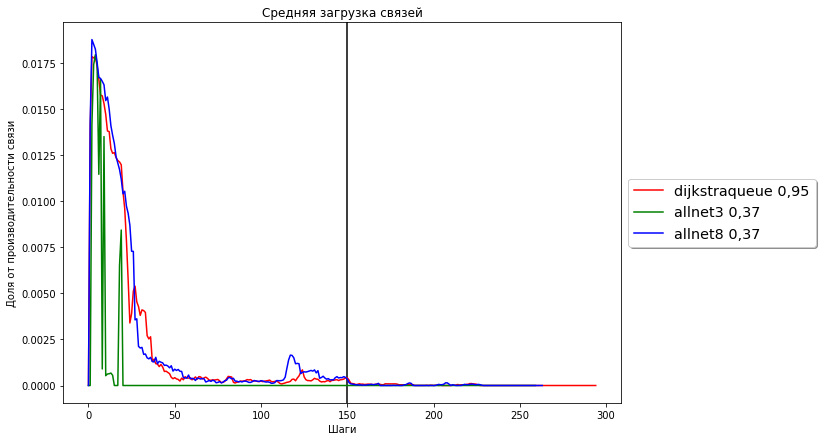

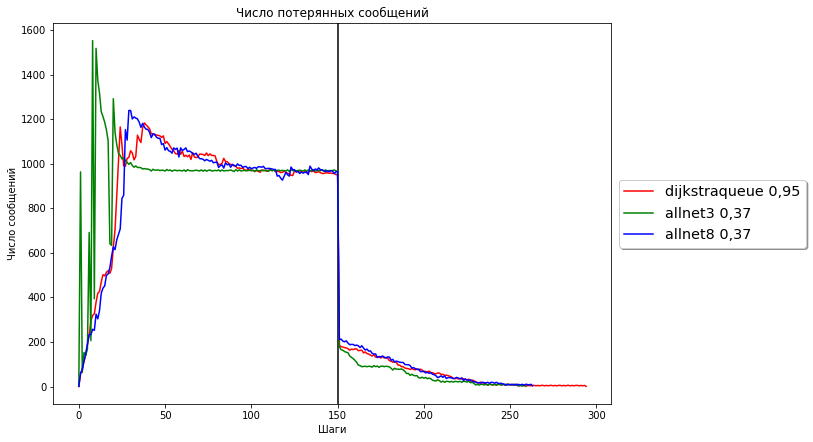

Доставлено 3138 Потеряно 97.9080% -dijkstraqueue 0,95
Доставлено 596 Потеряно 99.6027% -allnet3 0,37
Доставлено 3323 Потеряно 97.7847% -allnet8 0,37


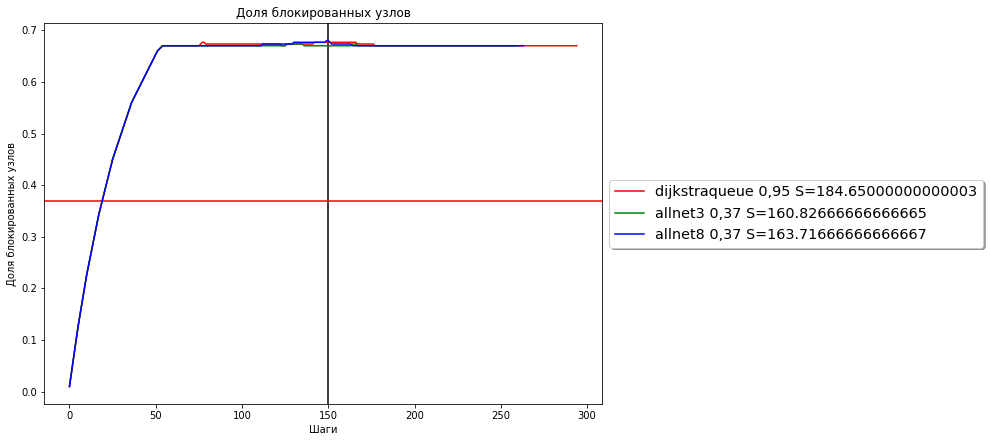

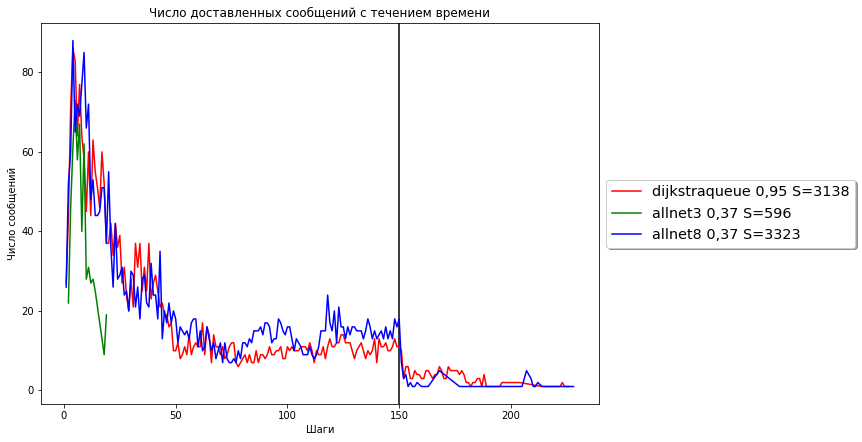

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "52b5ad4f-cc44-41d4-8a46-f678ea36786a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3e9c5593-7361-4835-b5ea-739d1fa3c5e0", "label": "allnet3 0,37", "color": "green"},
{"tag":  "3d024fdf-fa0a-41fe-9e4b-dc7664f67572", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

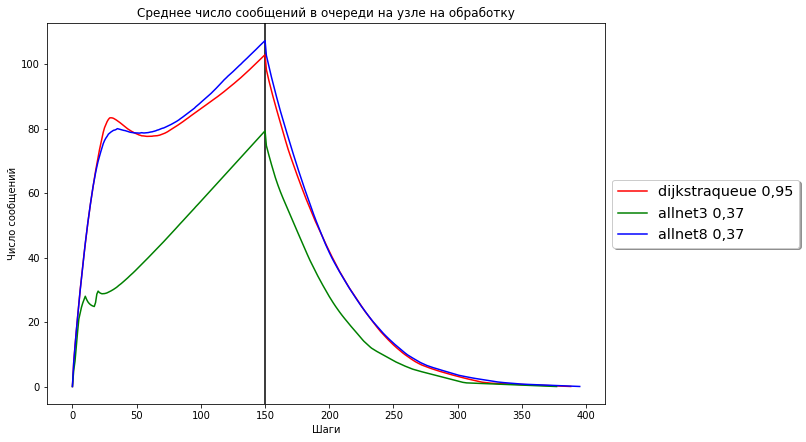

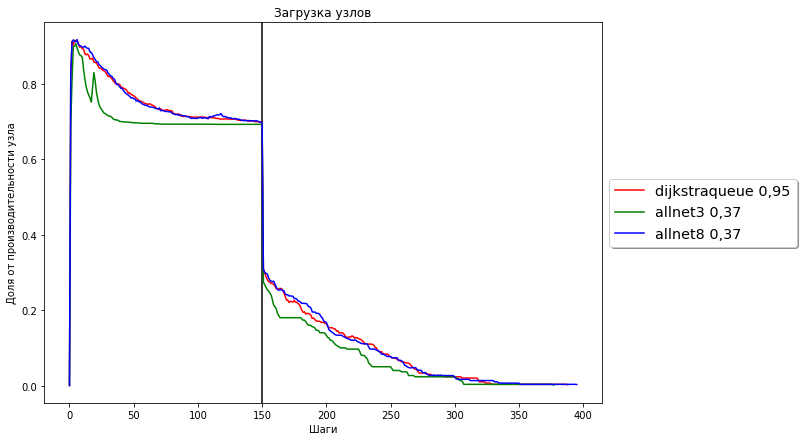

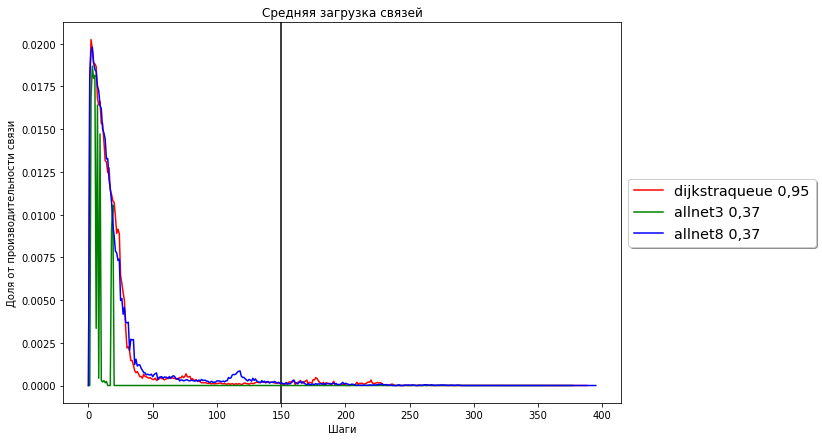

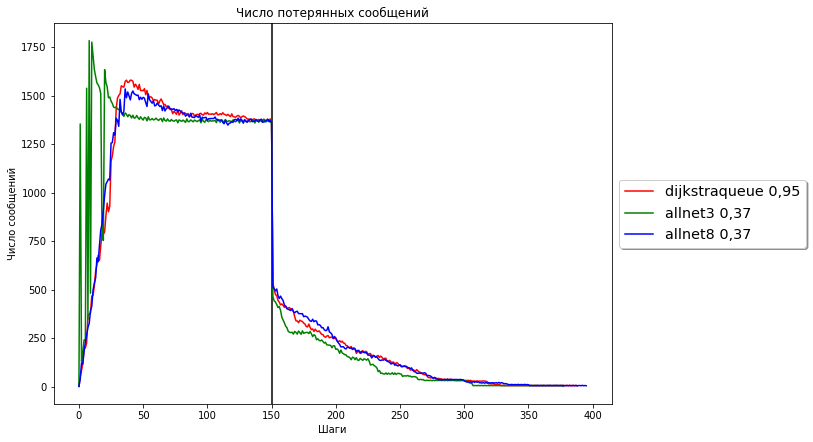

Доставлено 2948 Потеряно 98.6898% -dijkstraqueue 0,95
Доставлено 429 Потеряно 99.8093% -allnet3 0,37
Доставлено 3626 Потеряно 98.3885% -allnet8 0,37


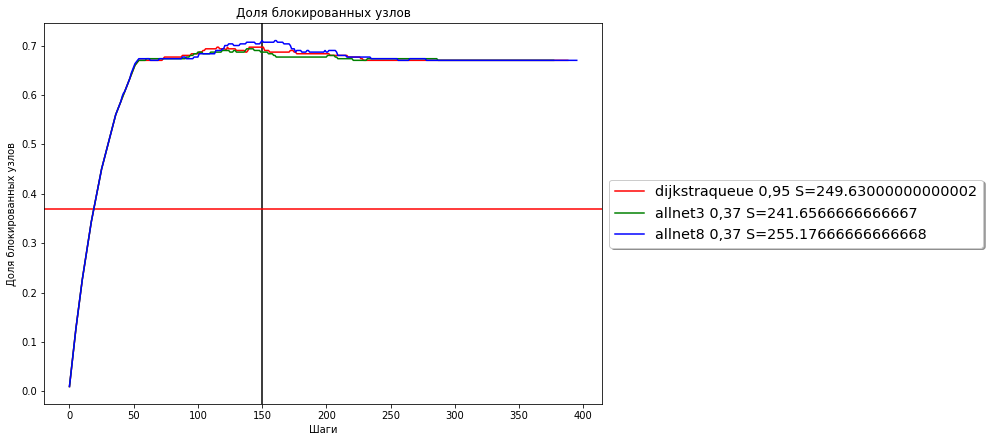

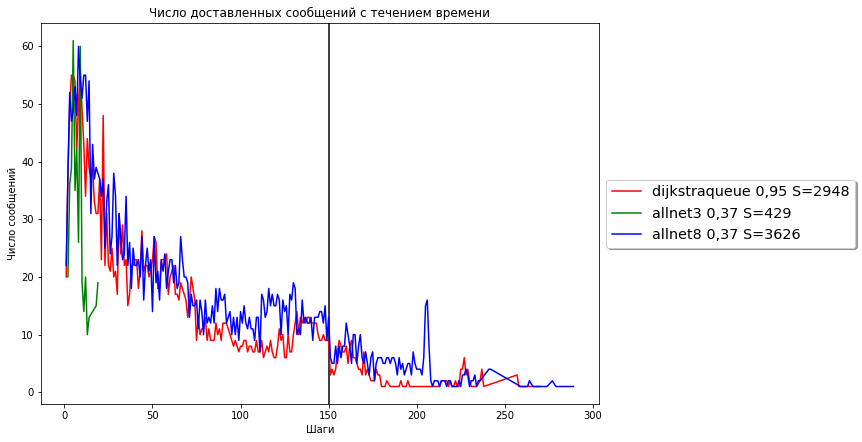

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "c40e3f30-a648-4d69-b6ac-e454cc39276d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "edee4f7c-dcc7-48f7-ad18-a4b69ddd16b8", "label": "allnet3 0,37", "color": "green"},
{"tag":  "594f3e31-c7da-4cb3-9ef1-334d63f4c7d7", "label": "allnet8 0,37", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 2327 Потеряно 94.8290% -dijkstraqueue 0,95
Доставлено 1022 Потеряно 97.7289% -allnet3 0,37
Доставлено 2228 Потеряно 95.0490% -allnet8 0,37


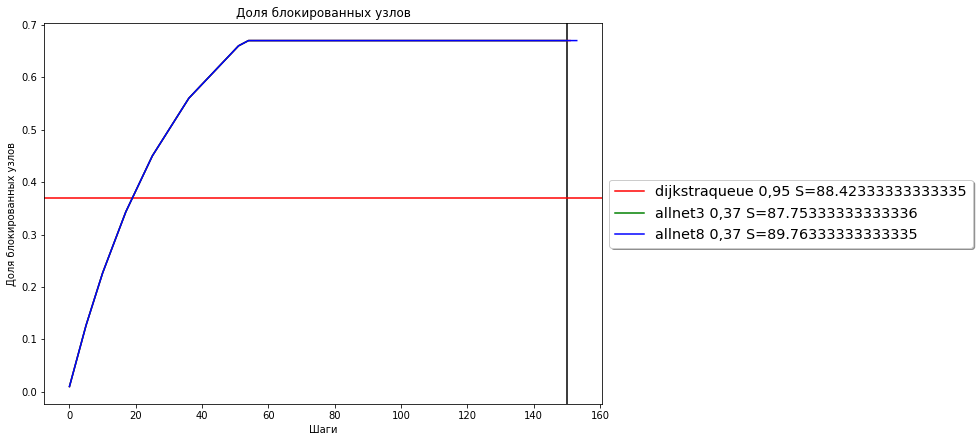

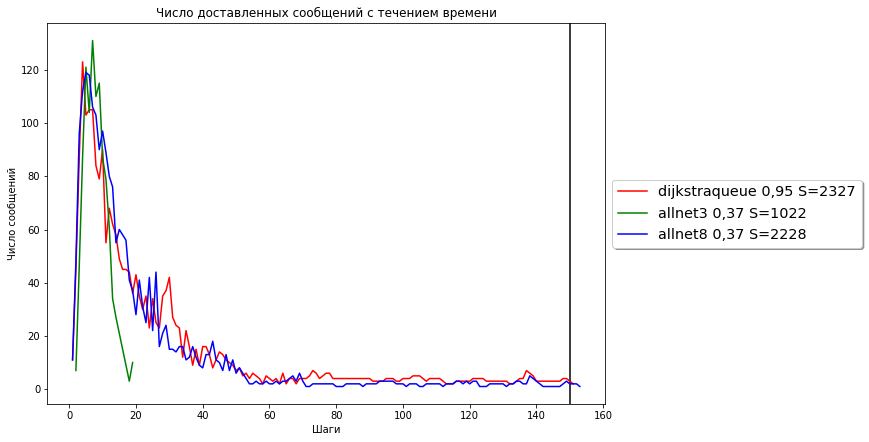

Доставлено 3231 Потеряно 96.9229% -dijkstraqueue 0,95
Доставлено 845 Потеряно 99.1952% -allnet3 0,37
Доставлено 3466 Потеряно 96.6991% -allnet8 0,37


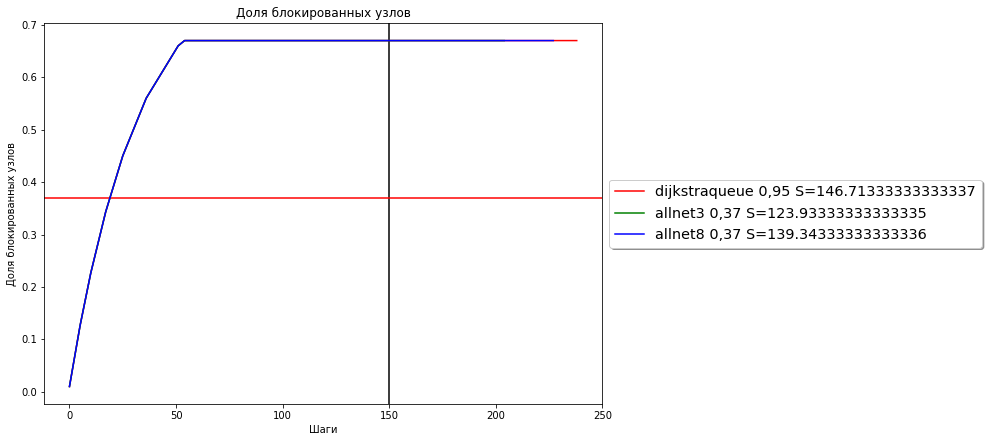

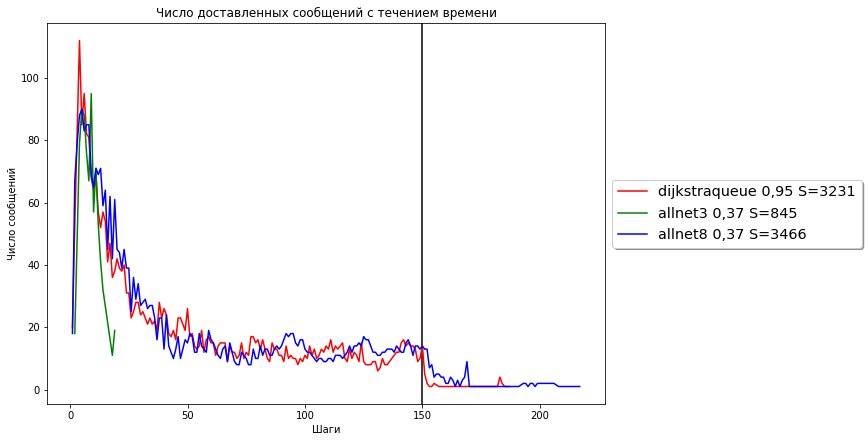

Доставлено 2966 Потеряно 97.8030% -dijkstraqueue 0,95
Доставлено 676 Потеряно 99.4993% -allnet3 0,37
Доставлено 2975 Потеряно 97.7963% -allnet8 0,37


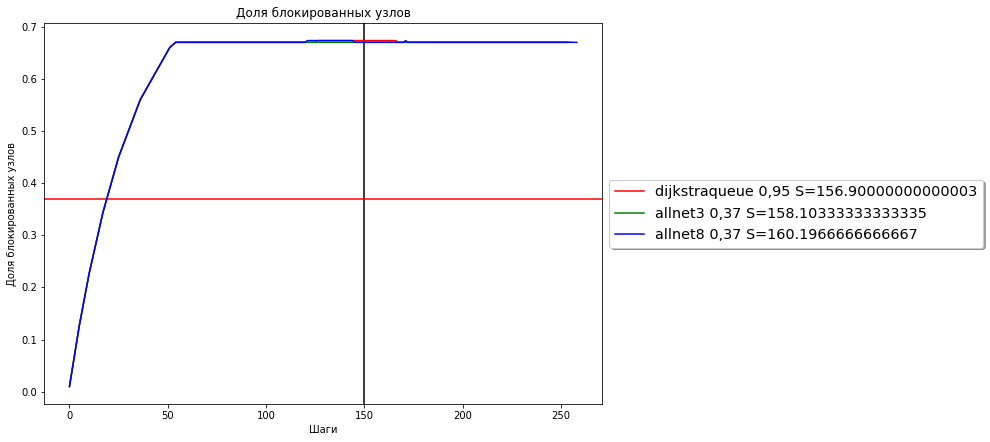

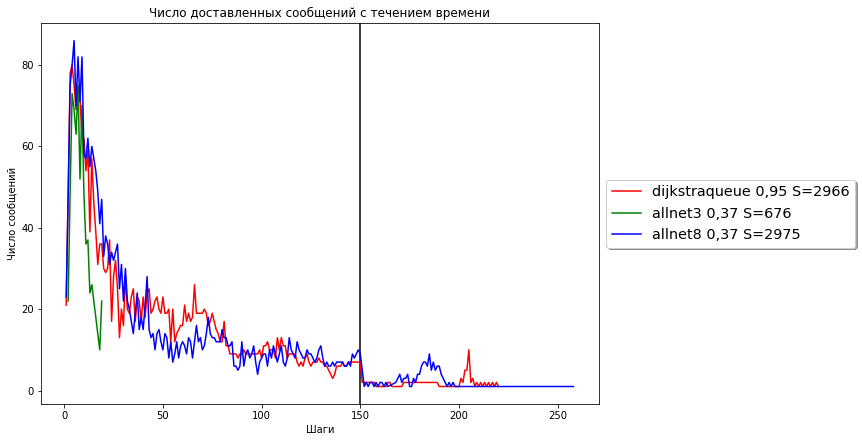

Доставлено 3057 Потеряно 98.4323% -dijkstraqueue 0,95
Доставлено 443 Потеряно 99.7728% -allnet3 0,37
Доставлено 3289 Потеряно 98.3133% -allnet8 0,37


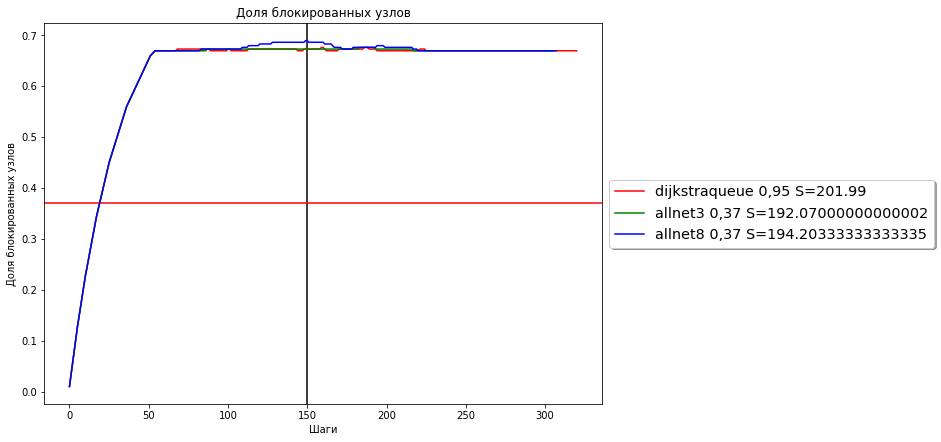

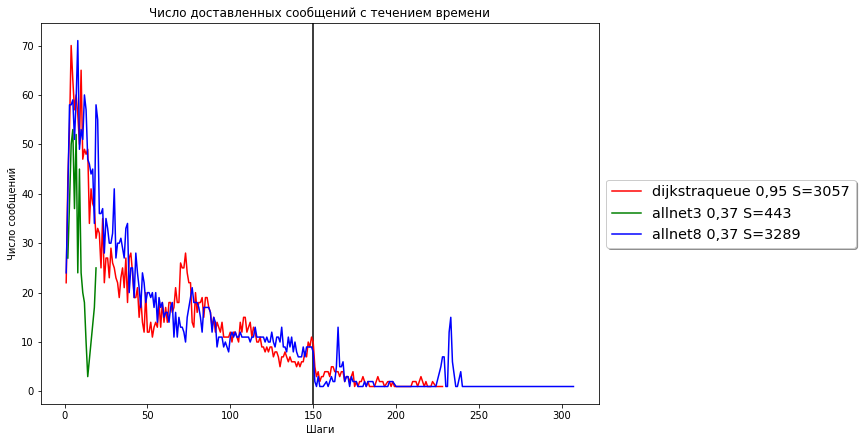

In [6]:
quantity = 300;
log_tags = [
{"tag":  "b870efd9-2778-4225-b1e2-3589fe85ddb2", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0d3d05ce-1d7d-4d8a-a69d-94b82465f2ac", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ba226843-c7c2-428f-abf4-655e5c20ebed", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "fe7fdd5b-d96e-4140-b72b-591bd7840261", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "bcd9c96f-e271-4108-a7b7-d3701c42c8d3", "label": "allnet3 0,37", "color": "green"},
{"tag":  "829b1065-05d8-43cc-a28a-32c349ffd731", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "1d12faab-e133-4ab8-9ad0-e308f28f68cb", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ee5093fb-3ce7-431a-a03e-c3ba19d6a9b5", "label": "allnet3 0,37", "color": "green"},
{"tag":  "9bf9907b-8766-4008-8756-a6fd44881db1", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "c3651e71-7252-41ba-ab8e-c24c54721e02", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "85213c75-44da-436e-8885-e902e7821337", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6582fc17-44cb-469e-a059-56aabe11a459", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

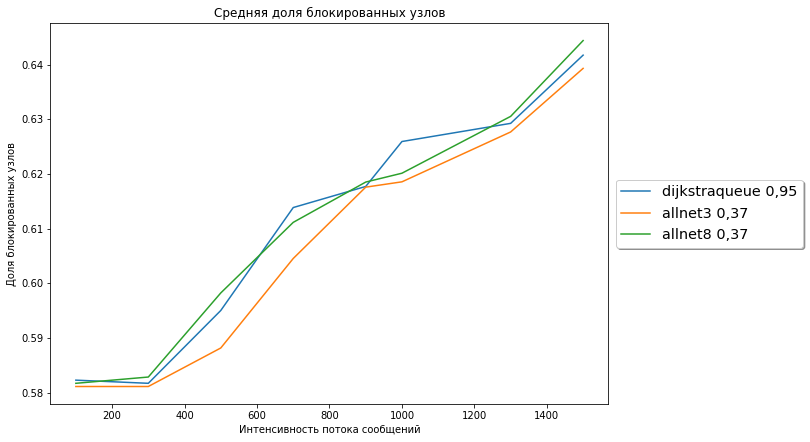

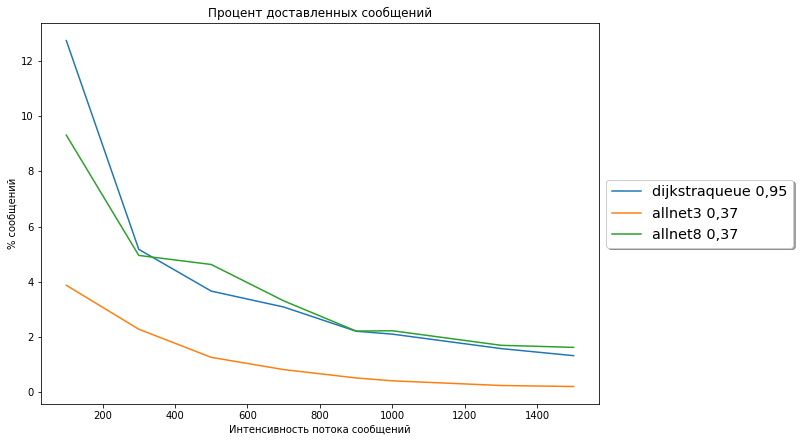

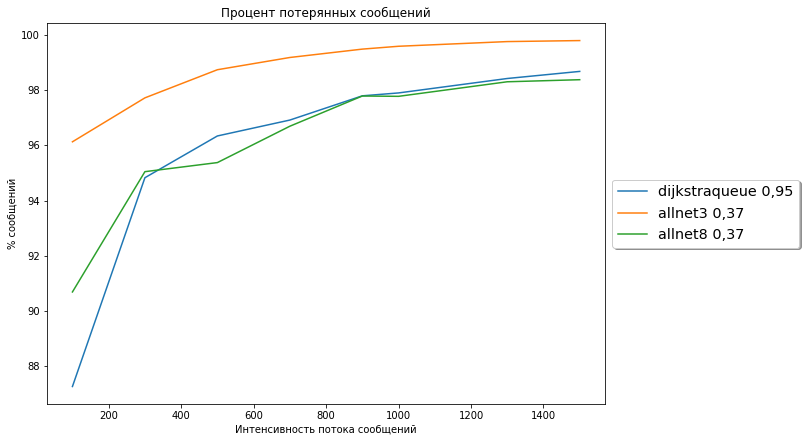

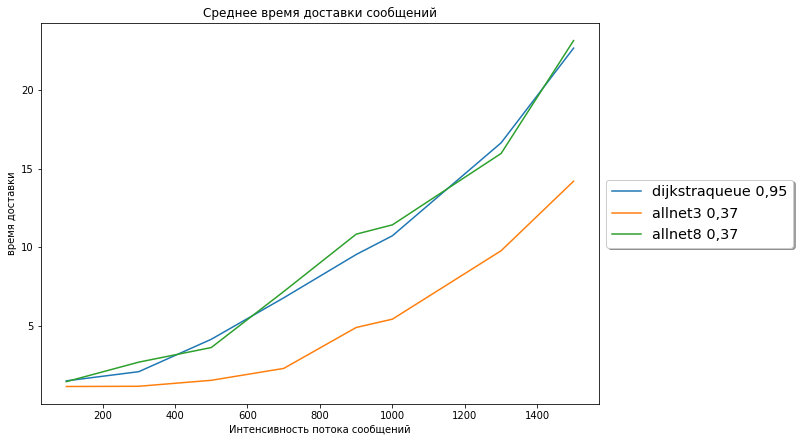

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.610947
allnet3 0,37          0.607272
allnet8 0,37          0.610949

dijkstraqueue 0,95    96.022235
allnet3 0,37          98.811568
allnet8 0,37          96.261277

dijkstraqueue 0,95    9.274289
allnet3 0,37          5.078721
allnet8 0,37          9.551497
